In [601]:
import gc

gc.collect()

45061

In [614]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from sktime.transformations.series.adapt import PandasTransformAdaptor
from sktime.utils import plotting
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import get_examples
from sktime.datatypes import check_raise
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from statsmodels.tsa.stattools import adfuller
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT
# Any results you write to the current directory are saved as output.


timestamp_Frequency = ['Weekly'] #'month'
if timestamp_Frequency[0] == 'Weekly':
    season_number_of_points = 52
    forecastingHorizon = 26
else:
    season_number_of_points = 12
    forecastingHorizon = 6
patience = 25

sp = season_number_of_points
timestamp = season_number_of_points
train_ratio = 0.5
if train_ratio < 0.5 :
    train_ratio = 0.5
usePipe = True #False is currently broken
useValidation = True
progressiveForecast = True

# datasetList = ['AirPassengers.csv','AirPassengers.csv']
datasetList = ["12141","18805","25472","26855","72758","90833","197456","566393"]


if (progressiveForecast):
    indirectForecastingHorizon = forecastingHorizon
    forecastingHorizon = 1
    realForecastingHorizon = indirectForecastingHorizon
else:
    realForecastingHorizon = forecastingHorizon

In [615]:
if (usePipe):
    print(len(datasetList))
    pipeTrain = list([])
    pipeTest = list([])
    for i in range (len(datasetList)):
        pipeTrain.append(TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
        ]))
        pipeTest.append(TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
        ]))
else :
    scalerTrain = list([])
    scalerTest = list([])
    for i in range (len(datasetList)):
        scalerTrain.append(MinMaxScaler(feature_range=(0,1)))
        scalerTest.append(MinMaxScaler(feature_range=(0,1)))
fullDataset = list([])
# print(pipeTrain)

8


In [616]:
for idxdataset, datasetName in enumerate(datasetList):
    print("New dataset : ",datasetName)
#     df = pd.read_csv(datasetName,parse_dates = timestamp_Frequency)
    # productNumber = "26855"
    datasetTarget="/home/esteban/Documents/Optimix/DeepAR/tools/correctedsupplyProduct_"+datasetName+".csv"
    df = pd.read_csv(datasetTarget, header=0, index_col=0)
    df.reset_index(inplace=True)
    df.head()
    dataset = df.iloc[:,1].values
#     fullDataset = np.append(fullDataset, dataset,axis=0)
#     print("fullDataset = ",fullDataset, type (fullDataset), dataset, type(dataset))
    fullDataset.append(dataset)
#     print("fullDataset = ",[fullDataset])
#     plt.xlabel('time')
#     plt.ylabel('number of passengers')
#     plt.title('International Airline Passenger')
    plt.show()
    train_size = int(len(dataset)*train_ratio)
    test_size = len(dataset) - train_size
    trainDataset = dataset[:train_size]
    testDataset = dataset[train_size:len(dataset)]
    print("idxdataset ",idxdataset)
#     print('train_size : {}, test_size : {}, total_size : {}'.format(len(trainDataset),len(testDataset),len(dataset)))
    if (idxdataset == 0):
        len_of_trainDataset = len(trainDataset)-timestamp-forecastingHorizon+1
        len_of_testDataset = len(testDataset)-timestamp-forecastingHorizon+1
        len_of_trainDataset_indirect = len(trainDataset)-timestamp-indirectForecastingHorizon+1
        len_of_testDataset_indirect = len(testDataset)-timestamp-indirectForecastingHorizon+1
        transformedTrainDatasetInputs = np.empty((0,len_of_trainDataset,timestamp))
        transformedTrainDatasetOutputs = np.empty((0,len_of_trainDataset,forecastingHorizon))
        transformedTestDatasetInputs = np.empty((0,len_of_testDataset,timestamp))
        transformedTestDatasetOutputs = np.empty((0,len_of_testDataset,forecastingHorizon))
        if (progressiveForecast):
            indirectTransformedTrainDatasetInputs = np.empty((0,len_of_trainDataset_indirect,timestamp))
            indirectTransformedTrainDatasetOutputs = np.empty((0,len_of_trainDataset_indirect,indirectForecastingHorizon))
            indirectTransformedTestDatasetInputs = np.empty((0,len_of_testDataset_indirect,timestamp))
            indirectTransformedTestDatasetOutputs = np.empty((0,len_of_testDataset_indirect,indirectForecastingHorizon))

    if (usePipe):
        transformedTrainDataset = pipeTrain[idxdataset].fit_transform(trainDataset)
        transformedTestDataset = pipeTest[idxdataset].fit_transform(testDataset)
#         print("test fitted 0", pipeTrain[0].check_is_fitted())
#         print("test fitted 1", pipeTrain[1].check_is_fitted())
#         print("test fitted 2", pipeTrain[2].check_is_fitted())
#         print("test fitted 3", pipeTrain[3].check_is_fitted())
#         print("test fitted 4", pipeTrain[4].check_is_fitted())
#         print("test fitted 5", pipeTrain[5].check_is_fitted())
    else:
        transformedTrainDataset = scalerTrain[idxdataset].fit_transform(trainDataset.reshape(-1, 1))
        transformedTestDataset = scalerTest[idxdataset].fit_transform(testDataset.reshape(-1, 1))

#     print("transformedTrainDataset : ", transformedTrainDataset.shape, "transformedTestDataset : ", transformedTestDataset.shape)
    dataX = []
    dataY = []
    for i in range(len(transformedTrainDataset)-timestamp-forecastingHorizon+1):
        a = transformedTrainDataset[i:(i+timestamp),0]
        b = transformedTrainDataset[(i+timestamp):(i+timestamp+forecastingHorizon),0]
        dataX.append(a)
        dataY.append(b)
    transformedTrainDatasetInputs = np.concatenate((transformedTrainDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
    transformedTrainDatasetOutputs = np.concatenate((transformedTrainDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
    print("transformedTrainDatasetInputs : ", transformedTrainDatasetInputs.shape, "transformedTrainDatasetOutputs : ", transformedTrainDatasetOutputs.shape)
    
    dataX = []
    dataY = []
    if(len(transformedTestDataset)-timestamp-forecastingHorizon+1)<=0:
        print( "Error : dataset size")
    for i in range(len(transformedTestDataset)-timestamp-forecastingHorizon+1):
        a = transformedTestDataset[i:(i+timestamp),0]
        b = transformedTestDataset[(i+timestamp):(i+timestamp+forecastingHorizon),0]
        dataX.append(a)
        dataY.append(b)
    transformedTestDatasetInputs = np.concatenate((transformedTestDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
    transformedTestDatasetOutputs = np.concatenate((transformedTestDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
    print("transformedTestDatasetInputs : ", transformedTestDatasetInputs.shape, "transformedTestDatasetOutputs : ", transformedTestDatasetOutputs.shape)

    if (progressiveForecast):
        dataX = []
        dataY = []
        for i in range(len(transformedTrainDataset)-timestamp-indirectForecastingHorizon+1):
            a = transformedTrainDataset[i:(i+timestamp),0]
            b = transformedTrainDataset[(i+timestamp):(i+timestamp+indirectForecastingHorizon),0]
            dataX.append(a)
            dataY.append(b)
        indirectTransformedTrainDatasetInputs = np.concatenate((indirectTransformedTrainDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
        indirectTransformedTrainDatasetOutputs = np.concatenate((indirectTransformedTrainDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
        print("indirectTransformedTrainDatasetInputs : ", indirectTransformedTrainDatasetInputs.shape, "indirectTransformedTrainDatasetOutputs : ", indirectTransformedTrainDatasetOutputs.shape)
        
        dataX = []
        dataY = []
        for i in range(len(transformedTestDataset)-timestamp-indirectForecastingHorizon+1):
            a = transformedTestDataset[i:(i+timestamp),0]
            b = transformedTestDataset[(i+timestamp):(i+timestamp+indirectForecastingHorizon),0]
            dataX.append(a)
            dataY.append(b)
        indirectTransformedTestDatasetInputs = np.concatenate((indirectTransformedTestDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
        indirectTransformedTestDatasetOutputs = np.concatenate((indirectTransformedTestDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
        print("indirectTransformedTestDatasetInputs : ", indirectTransformedTestDatasetInputs.shape, "indirectTransformedTestDatasetOutputs : ", indirectTransformedTestDatasetOutputs.shape)


New dataset :  12141
idxdataset  0
transformedTrainDatasetInputs :  (1, 26, 52) transformedTrainDatasetOutputs :  (1, 26, 1)
transformedTestDatasetInputs :  (1, 27, 52) transformedTestDatasetOutputs :  (1, 27, 1)
indirectTransformedTrainDatasetInputs :  (1, 1, 52) indirectTransformedTrainDatasetOutputs :  (1, 1, 26)
indirectTransformedTestDatasetInputs :  (1, 2, 52) indirectTransformedTestDatasetOutputs :  (1, 2, 26)
New dataset :  18805
idxdataset  1
transformedTrainDatasetInputs :  (2, 26, 52) transformedTrainDatasetOutputs :  (2, 26, 1)
transformedTestDatasetInputs :  (2, 27, 52) transformedTestDatasetOutputs :  (2, 27, 1)
indirectTransformedTrainDatasetInputs :  (2, 1, 52) indirectTransformedTrainDatasetOutputs :  (2, 1, 26)
indirectTransformedTestDatasetInputs :  (2, 2, 52) indirectTransformedTestDatasetOutputs :  (2, 2, 26)
New dataset :  25472
idxdataset  2
transformedTrainDatasetInputs :  (3, 26, 52) transformedTrainDatasetOutputs :  (3, 26, 1)
transformedTestDatasetInputs :  (

In [617]:
print('transformedTrainDatasetInputs shape : {}, transformedTestDatasetInputs original shape : {}'.format(transformedTrainDatasetInputs.shape,transformedTestDatasetInputs.shape))
print('transformedTrainDatasetOutputs shape : {}, transformedTestDatasetOutputs original shape : {}'.format(transformedTrainDatasetOutputs.shape,transformedTestDatasetOutputs.shape))

reshapedTransformedTrainDatasetInputs = np.reshape(transformedTrainDatasetInputs,(-1,1,transformedTrainDatasetInputs.shape[2])) #(number of points, features number, lookback)
reshapedTransformedTestDatasetInputs = np.reshape(transformedTestDatasetInputs,(-1,1,transformedTestDatasetInputs.shape[2]))

reshapedTransformedTrainDatasetOutputs = np.reshape(transformedTrainDatasetOutputs,(-1,transformedTrainDatasetOutputs.shape[2])) #(number of points, features number, lookback)
reshapedTransformedTestDatasetOutputs = np.reshape(transformedTestDatasetOutputs,(-1,transformedTestDatasetOutputs.shape[2]))

if (progressiveForecast):
    print(indirectTransformedTestDatasetOutputs.shape)
    reshapedIndirectTransformedTestDatasetOutputs = np.reshape(indirectTransformedTestDatasetOutputs,(-1,indirectTransformedTestDatasetOutputs.shape[2]))
print('\nreshapedTransformedTrainDatasetInputs shape : {}, reshapedTransformedTestDatasetInputs shape : {}'.format(reshapedTransformedTrainDatasetInputs.shape,reshapedTransformedTestDatasetInputs.shape))
print('reshapedTransformedTrainDatasetOutputs shape : {}, reshapedTransformedTestDatasetOutputs shape : {}'.format(reshapedTransformedTrainDatasetOutputs.shape,reshapedTransformedTestDatasetOutputs.shape))

#IMPORTANT : FORMAT IS (NUMBER OF TIME SERIES, NUMBER OF INPUTS COMBINATIONS, SIZE OF INPUT)

transformedTrainDatasetInputs shape : (8, 26, 52), transformedTestDatasetInputs original shape : (8, 27, 52)
transformedTrainDatasetOutputs shape : (8, 26, 1), transformedTestDatasetOutputs original shape : (8, 27, 1)
(8, 2, 26)

reshapedTransformedTrainDatasetInputs shape : (208, 1, 52), reshapedTransformedTestDatasetInputs shape : (216, 1, 52)
reshapedTransformedTrainDatasetOutputs shape : (208, 1), reshapedTransformedTestDatasetOutputs shape : (216, 1)


Train on 208 samples, validate on 216 samples
Epoch 1/1000
180/208 [========================>.....] - ETA: 0s - loss: 0.0760

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


208/208 [==============================] - 1s 4ms/sample - loss: 0.0742 - val_loss: 0.0641
Epoch 2/1000
208/208 [==============================] - 1s 3ms/sample - loss: 0.0457 - val_loss: 0.0602
Epoch 3/1000
208/208 [==============================] - 1s 3ms/sample - loss: 0.0440 - val_loss: 0.0596
Epoch 4/1000
208/208 [==============================] - 1s 3ms/sample - loss: 0.0428 - val_loss: 0.0606
Epoch 5/1000
208/208 [==============================] - 1s 2ms/sample - loss: 0.0424 - val_loss: 0.0574
Epoch 6/1000
208/208 [==============================] - 0s 2ms/sample - loss: 0.0408 - val_loss: 0.0563
Epoch 7/1000
208/208 [==============================] - 0s 2ms/sample - loss: 0.0395 - val_loss: 0.0538
Epoch 8/1000
208/208 [==============================] - 0s 2ms/sample - loss: 0.0389 - val_loss: 0.0549
Epoch 9/1000
208/208 [==============================] - 1s 3ms/sample - loss: 0.0380 - val_loss: 0.0553
Epoch 10/1000
208/208 [==============================] - 0s 2ms/sample - loss

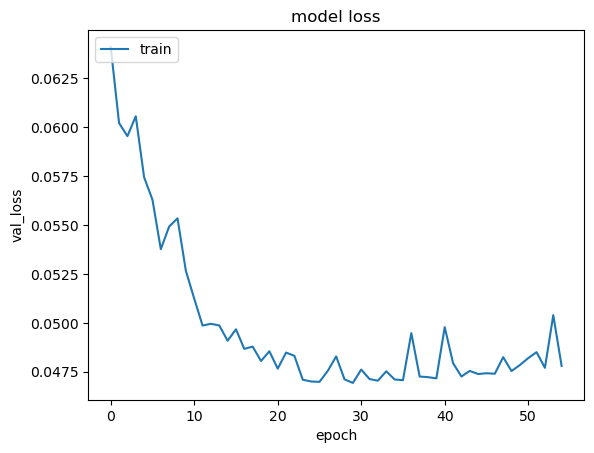

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                10880     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 10,913
Trainable params: 10,913
Non-trainable params: 0
_________________________________________________________________
None


In [618]:
# print(trainY.shape[2])
# model
model = Sequential()
# model.add(Dense(32))
# model.add(LSTM(32)) # 10 lstm neuron(block)
model.add(LSTM(32, input_shape=(1, timestamp))) # 10 lstm neuron(block)
model.add(Dense(forecastingHorizon))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)) #'adam'
# history = model.fit(trainX, trainY, epochs=50, batch_size=1)
# print(model.output_shape)
if (useValidation):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.00005)
    ]
    history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=1000, batch_size=1, validation_data=(reshapedTransformedTestDatasetInputs,reshapedTransformedTestDatasetOutputs), callbacks=callbacks)
    plt.title('model loss')
    try :
        plt.plot(history.history['val_loss'])
        plt.ylabel('val_loss')
    except : 
        plt.plot(history.history['loss'])
        plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
else :
    callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience, monitor="loss",min_delta=0.00005)
    ]
    history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=1000, batch_size=1, callbacks=callbacks)
    plt.title('model loss')
    plt.plot(history.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
# tf.keras.utils.plot_model(model, show_shapes=True)
print(model.summary())

In [619]:
if (progressiveForecast):
    finalTrainPredictionOutput = [[[np.nan for k in range(indirectForecastingHorizon)] for j in range(len(indirectTransformedTrainDatasetInputs[1]))] for i in range(len(datasetList))]
    finalTestPredictionOutput = [[[np.nan for k in range(indirectForecastingHorizon)] for j in range(len(indirectTransformedTestDatasetInputs[1]))] for i in range(len(datasetList))]
    for idxdataset, datasetName in enumerate(datasetList):
        for indexTimeSerie in range (0,len(indirectTransformedTrainDatasetInputs[1])):
            currentInputsArray = indirectTransformedTrainDatasetInputs[idxdataset][indexTimeSerie]
            predictionOutput = []
            for i in range (0,indirectForecastingHorizon,1):
                currentOutput = model.predict(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])))
                currentInputsArray = np.delete(currentInputsArray, 0)
                currentInputsArray = np.append(currentInputsArray,currentOutput[0][0])
                predictionOutput.append(currentOutput[0][0])
            finalTrainPredictionOutput[idxdataset][indexTimeSerie] = predictionOutput
        for indexTimeSerie in range (0,len(indirectTransformedTestDatasetInputs[1])):
            currentInputsArray = indirectTransformedTestDatasetInputs[idxdataset][indexTimeSerie]
            predictionOutput = []
            for i in range (0,indirectForecastingHorizon,1):
                currentOutput = model.predict(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])))
                currentInputsArray = np.delete(currentInputsArray, 0)
                currentInputsArray = np.append(currentInputsArray,currentOutput[0][0])
                predictionOutput.append(currentOutput[0][0])
            finalTestPredictionOutput[idxdataset][indexTimeSerie] = predictionOutput
    transformedTrainDatasetPredictions = np.array(finalTrainPredictionOutput)
    transformedTestDatasetPredictions = np.array(finalTestPredictionOutput)

    print("Progressive Forecasting has been used")
else :
    transformedTrainDatasetPredictions = model.predict(reshapedTransformedTrainDatasetInputs).reshape(len(fullDataset),-1,forecastingHorizon)
    transformedTestDatasetPredictions = model.predict(reshapedTransformedTestDatasetInputs).reshape(len(fullDataset),-1,forecastingHorizon)

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Progressive Forecasting has been used


In [620]:
print("transformedTrainDatasetPredictions : ", transformedTrainDatasetPredictions.shape, "transformedTestDatasetPredictions : ", transformedTestDatasetPredictions.shape)

if usePipe :
    TrainDatasetInputs = np.empty((0,transformedTrainDatasetInputs.shape[1],timestamp))
    TrainDatasetOutputs = np.empty((0,transformedTrainDatasetOutputs.shape[1],forecastingHorizon))
    TrainDatasetPredictions = np.empty((0,transformedTrainDatasetPredictions.shape[1],realForecastingHorizon))
    TestDatasetInputs = np.empty((0,transformedTestDatasetInputs.shape[1],timestamp))
    TestDatasetOutputs = np.empty((0,transformedTestDatasetInputs.shape[1],forecastingHorizon))
    TestDatasetPredictions = np.empty((0,transformedTestDatasetPredictions.shape[1],realForecastingHorizon))
    for (idx, dataset) in enumerate(datasetList) :
        print("\nValues for Dataset ",idx)
        trainInputsRange = reshapedTransformedTrainDatasetInputs[idx*transformedTrainDatasetInputs.shape[1]:(idx+1)*transformedTrainDatasetInputs.shape[1]].reshape(-1,1)
        TrainDatasetInputs = np.append(TrainDatasetInputs,pipeTrain[idx].inverse_transform(trainInputsRange).reshape(1,-1,timestamp), axis = 0)
        print("Train Inputs Shape : ", TrainDatasetInputs.shape)
        
        trainOutputsRange = reshapedTransformedTrainDatasetOutputs[idx*transformedTrainDatasetOutputs.shape[1]:(idx+1)*transformedTrainDatasetOutputs.shape[1]].reshape(-1,1)
        TrainDatasetOutputs = np.append(TrainDatasetOutputs, pipeTrain[idx].inverse_transform(trainOutputsRange).reshape(1,-1,forecastingHorizon), axis = 0)
        print("Train Outputs Shape : ", TrainDatasetOutputs.shape)
        
        trainPredictionsRange = (transformedTrainDatasetPredictions.reshape(-1,1)[idx*transformedTrainDatasetPredictions.shape[1]*transformedTrainDatasetPredictions.shape[2]:(idx+1)*transformedTrainDatasetPredictions.shape[1]*transformedTrainDatasetPredictions.shape[2]])
        TrainDatasetPredictions = np.append(TrainDatasetPredictions, pipeTrain[idx].inverse_transform(trainPredictionsRange).reshape(1,-1,realForecastingHorizon), axis = 0)
        print("Train Predictions Shape : ", TrainDatasetPredictions.shape)

        testInputsRange = reshapedTransformedTestDatasetInputs.reshape(-1,1)[idx*timestamp*transformedTestDatasetInputs.shape[1]:(idx+1)*timestamp*transformedTestDatasetInputs.shape[1]]
        TestDatasetInputs = np.append(TestDatasetInputs, pipeTest[idx].inverse_transform(testInputsRange).reshape(1,-1,timestamp),axis=0)
        print("Test Inputs Shape : ", TestDatasetInputs.shape)
        
        if (progressiveForecast):
            testOutputsRange = reshapedTransformedTestDatasetOutputs[idx*transformedTestDatasetOutputs.shape[1]:(idx+1)*transformedTestDatasetOutputs.shape[1]].reshape(-1,1)
            TestDatasetOutputs = np.append(TestDatasetOutputs, pipeTest[idx].inverse_transform(testOutputsRange).reshape(1,-1,forecastingHorizon),axis=0)
            print("Test Outputs Shape : ", TestDatasetOutputs.shape)
            
            testPredictionsRange = (transformedTestDatasetPredictions.reshape(-1,1)[idx*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]:(idx+1)*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]])
            print(TestDatasetPredictions.shape, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,forecastingHorizon).shape)
            TestDatasetPredictions = np.append(TestDatasetPredictions, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,realForecastingHorizon), axis = 0)
            print("Test Predictions Shape : ", TestDatasetPredictions.shape)
        else:
#             print("range ", np.array(reshapedTransformedTestDatasetOutputs).shape)
            testOutputsRange = reshapedTransformedTestDatasetOutputs[idx*transformedTestDatasetOutputs.shape[1]:(idx+1)*transformedTestDatasetOutputs.shape[1]].reshape(-1,1)
            TestDatasetOutputs = np.append(TestDatasetOutputs, pipeTest[idx].inverse_transform(testOutputsRange).reshape(1,-1,forecastingHorizon),axis=0)
            print("Test Outputs Shape : ", TestDatasetOutputs.shape)
            testPredictionsRange = transformedTestDatasetPredictions.reshape(-1,1)[idx*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]:(idx+1)*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]]
            TestDatasetPredictions = np.append(TestDatasetPredictions, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,forecastingHorizon),axis=0)
            print("Test Predictions Shape : ", TestDatasetPredictions.shape)
            # TrainDatasetOutputs = TrainDatasetOutputs.reshape(TrainDatasetOutputs.shape[0],TrainDatasetOutputs.shape[2],TrainDatasetOutputs.shape[1])
            # TrainDatasetPredictions = TrainDatasetPredictions.reshape(TrainDatasetPredictions.shape[0],TrainDatasetPredictions.shape[2],TrainDatasetPredictions.shape[1])


else :
    for (idx, dataset) in enumerate(datasetList) :     
        TrainDatasetInputs = scalerTrain[idx].inverse_transform(reshapedTransformedTrainDatasetInputs.reshape(-1,1)).reshape(len(fullDataset),-1,timestamp)
        TrainDatasetOutputs = scalerTrain[idx].inverse_transform(reshapedTransformedTrainDatasetOutputs.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
        TrainDatasetPredictions = scalerTrain[idx].inverse_transform(TransformedTrainDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
        TestDatasetInputs = scalerTest[idx].inverse_transform(reshapedTransformedTestDatasetInputs.reshape(-1,1)).reshape(len(fullDataset),-1,timestamp)
        if (progressiveForecast):
            TestDatasetOutputs = scalerTest[idx].inverse_transform(np.array(reshapedIndirectTransformedTestDatasetOutputs).reshape(-1,1)).reshape(len(fullDataset),-1,indirectForecastingHorizon)
            TestDatasetPredictions = scalerTest[idx].inverse_transform(TransformedTestDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,indirectForecastingHorizon)
        else : 
            TestDatasetOutputs = scalerTest[idx].inverse_transform(reshapedTransformedTestDatasetOutputs.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
            TestDatasetPredictions = scalerTest[idx].inverse_transform(TransformedTestDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)

print(TrainDatasetInputs.shape, TrainDatasetOutputs.shape, TrainDatasetPredictions.shape, TestDatasetInputs.shape, TestDatasetOutputs.shape, TestDatasetPredictions.shape)
#doit être (nombre de dataset, nombre de combinaisons, timestamp)

transformedTrainDatasetPredictions :  (8, 1, 26) transformedTestDatasetPredictions :  (8, 2, 26)

Values for Dataset  0
Train Inputs Shape :  (1, 26, 52)
Train Outputs Shape :  (1, 26, 1)
Train Predictions Shape :  (1, 1, 26)
Test Inputs Shape :  (1, 27, 52)
Test Outputs Shape :  (1, 27, 1)
(0, 2, 26) (1, 52, 1)
Test Predictions Shape :  (1, 2, 26)

Values for Dataset  1
Train Inputs Shape :  (2, 26, 52)
Train Outputs Shape :  (2, 26, 1)
Train Predictions Shape :  (2, 1, 26)
Test Inputs Shape :  (2, 27, 52)
Test Outputs Shape :  (2, 27, 1)
(1, 2, 26) (1, 52, 1)
Test Predictions Shape :  (2, 2, 26)

Values for Dataset  2
Train Inputs Shape :  (3, 26, 52)
Train Outputs Shape :  (3, 26, 1)
Train Predictions Shape :  (3, 1, 26)
Test Inputs Shape :  (3, 27, 52)
Test Outputs Shape :  (3, 27, 1)
(2, 2, 26) (1, 52, 1)
Test Predictions Shape :  (3, 2, 26)

Values for Dataset  3
Train Inputs Shape :  (4, 26, 52)
Train Outputs Shape :  (4, 26, 1)
Train Predictions Shape :  (4, 1, 26)
Test Inputs 

In [621]:
if (progressiveForecast):
    TrainDatasetOutputs = TrainDatasetOutputs.reshape(TrainDatasetOutputs.shape[0],TrainDatasetOutputs.shape[2],TrainDatasetOutputs.shape[1])
#     TrainDatasetPredictions = TrainDatasetPredictions.reshape(TrainDatasetPredictions.shape[0],TrainDatasetPredictions.shape[2],TrainDatasetPredictions.shape[1])
# print(TrainDatasetOutputs[idx][0][0:realForecastingHorizon].shape)
# print(TrainDatasetPredictions[idx][0].shape)
for (idx, dataset) in enumerate(datasetList) : 
    print("\nValues for Dataset ",idx)
#     print(TestDatasetOutputs[idx][0:indirectForecastingHorizon].shape,TestDatasetPredictions[idx][0].shape)
    trainScore = math.sqrt(mean_squared_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
    print('Test Score: %.2f RMSE' % (testScore))
    trainScore2 = math.sqrt(mean_absolute_percentage_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
    print('Train Score: %.2f MAPE' % (trainScore2))
    testScore2 = math.sqrt(mean_absolute_percentage_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
    print('Test Score: %.2f MAPE' % (testScore2))

(26,)
(26,)

Values for Dataset  0
Train Score: 178.26 RMSE
Test Score: 178.26 RMSE
Train Score: 0.52 MAPE
Test Score: 0.52 MAPE

Values for Dataset  1
Train Score: 193.77 RMSE
Test Score: 193.77 RMSE
Train Score: 0.60 MAPE
Test Score: 0.60 MAPE

Values for Dataset  2
Train Score: 60.95 RMSE
Test Score: 60.95 RMSE
Train Score: 0.40 MAPE
Test Score: 0.40 MAPE

Values for Dataset  3
Train Score: 311.61 RMSE
Test Score: 311.61 RMSE
Train Score: 0.38 MAPE
Test Score: 0.38 MAPE

Values for Dataset  4
Train Score: 416.25 RMSE
Test Score: 416.25 RMSE
Train Score: 0.58 MAPE
Test Score: 0.58 MAPE

Values for Dataset  5
Train Score: 1453.49 RMSE
Test Score: 1453.49 RMSE
Train Score: 0.40 MAPE
Test Score: 0.40 MAPE

Values for Dataset  6
Train Score: 416.37 RMSE
Test Score: 416.37 RMSE
Train Score: 0.37 MAPE
Test Score: 0.37 MAPE

Values for Dataset  7
Train Score: 275.66 RMSE
Test Score: 275.66 RMSE
Train Score: 0.44 MAPE
Test Score: 0.44 MAPE


DATASET  NUMBER  0


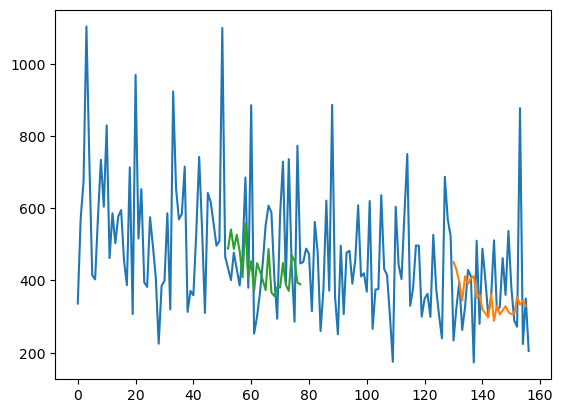

DATASET  NUMBER  1


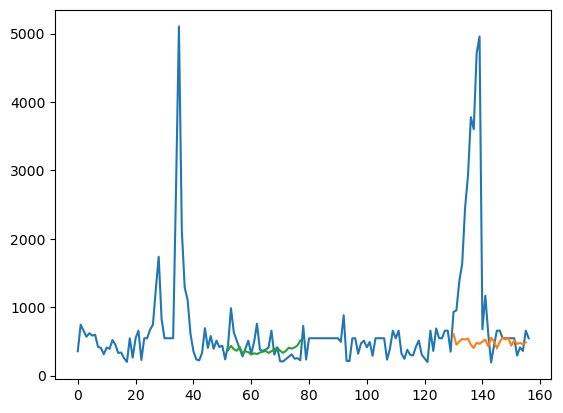

DATASET  NUMBER  2


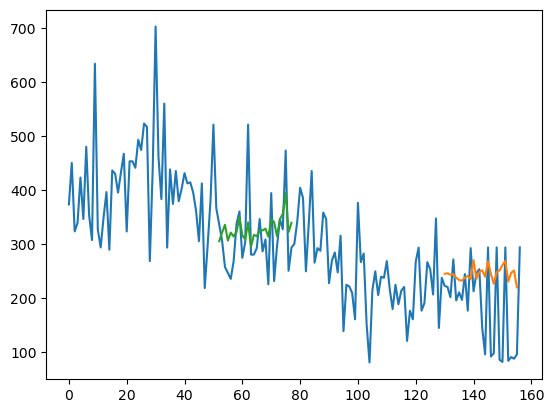

DATASET  NUMBER  3


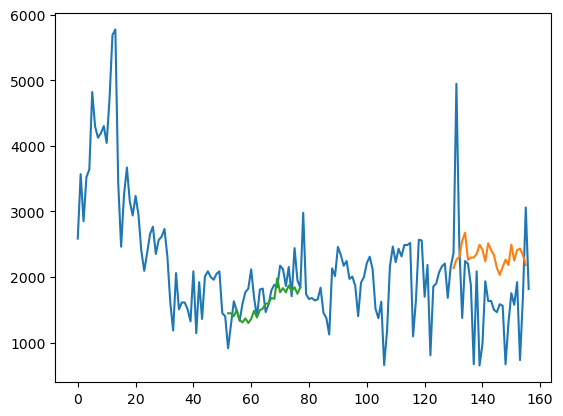

DATASET  NUMBER  4


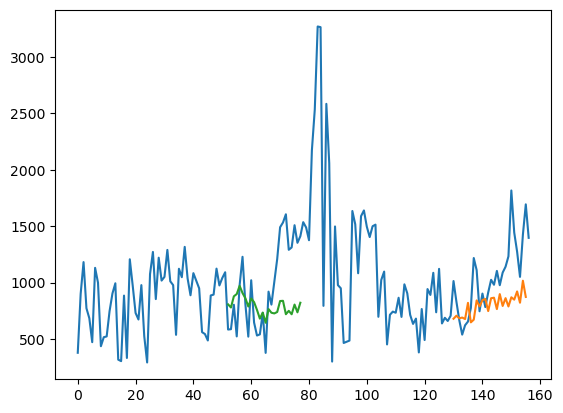

DATASET  NUMBER  5


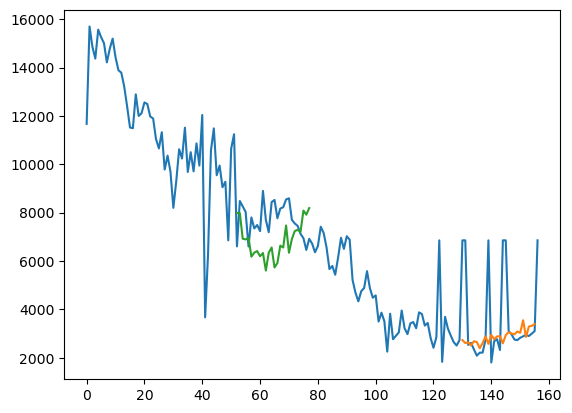

DATASET  NUMBER  6


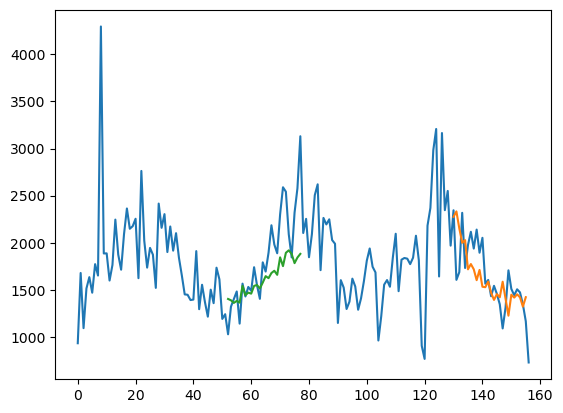

DATASET  NUMBER  7


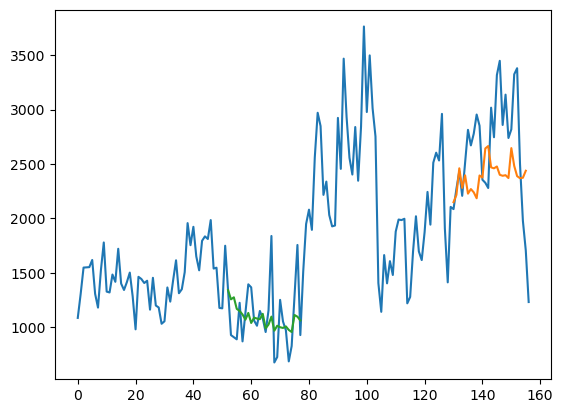

In [622]:
for (idx, dataset) in enumerate(fullDataset) : 
#     print(dataset)
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot = [np.nan] * len(trainPredictPlot)
#     print(len(TrainDatasetPredictions[idx][0]), len(trainPredictPlot))
    trainPredictPlot[timestamp:len(TrainDatasetPredictions[idx][0])+timestamp] = TrainDatasetPredictions[idx,0,:]
    forecastingDepthIndexToPlot = 0
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot = [np.nan] * len(testPredictPlot)
    testPredictPlot[len(TrainDatasetPredictions[idx][0])+(timestamp*2)+forecastingHorizon+forecastingDepthIndexToPlot-1:len(dataset)-1] = TestDatasetPredictions[idx,forecastingDepthIndexToPlot,:]
    # print(len(TestDatasetPredictions[:,0]),len(trainPredict)+(timestamp*2)+1+forecastingHorizon, len(dataset)-1)
    print("DATASET  NUMBER ", idx)
    plt.plot(dataset)
    plt.plot(testPredictPlot)
    plt.plot(trainPredictPlot)
    plt.show()


In [623]:
for (idx, dataset) in enumerate(fullDataset) : 
    if (not(progressiveForecast)):
        for index in range (len(TrainDatasetPredictions[idx])):

            individualTrainInputsPlot = np.empty_like(dataset)
            individualTrainInputsPlot = [np.nan] * len(individualTrainInputsPlot)
            individualTrainInputsPlot[index:timestamp+index] = TrainDatasetInputs[idx,index]

            individualTrainPredictPlot = np.empty_like(dataset)
            individualTrainPredictPlot = [np.nan] * len(individualTrainPredictPlot)
            individualTrainPredictPlot[index+timestamp:timestamp+index+forecastingHorizon] = TrainDatasetPredictions[idx,index]

            plt.plot(dataset)
            plt.plot(individualTrainPredictPlot)
            plt.plot(individualTrainInputsPlot)
            plt.show()

forecastingHorizon 1 indirectForecastingHorizon  26
(2, 26)
26


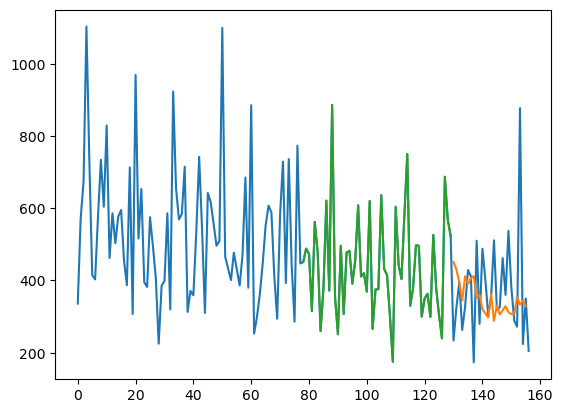

26


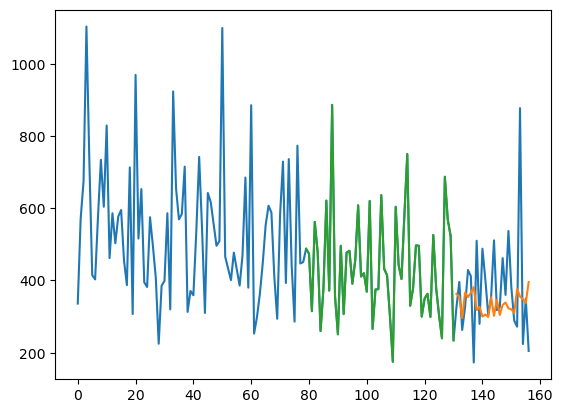

(2, 26)
26


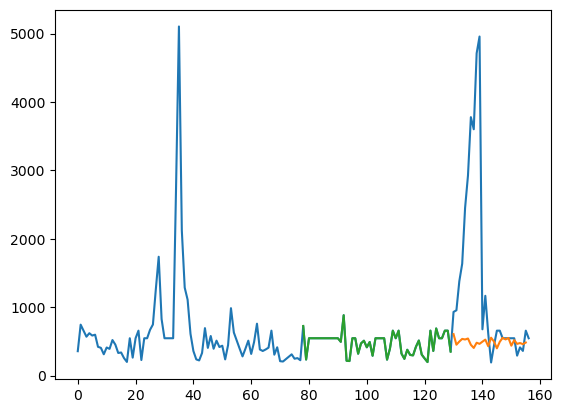

26


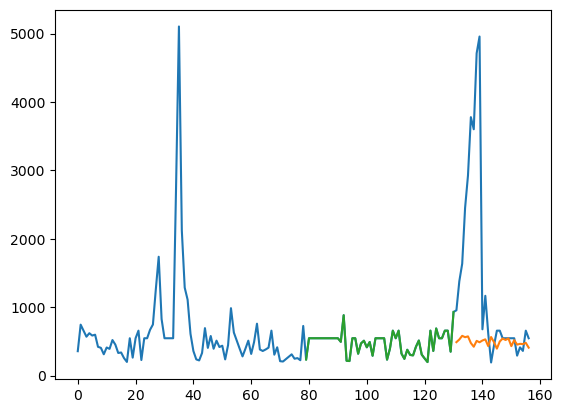

(2, 26)
26


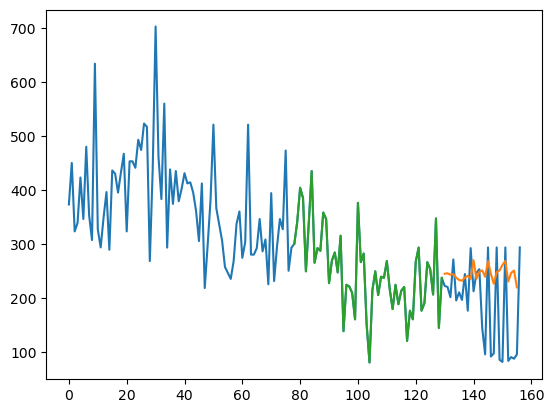

26


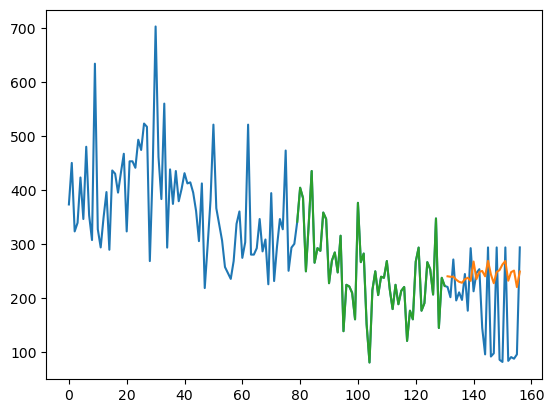

(2, 26)
26


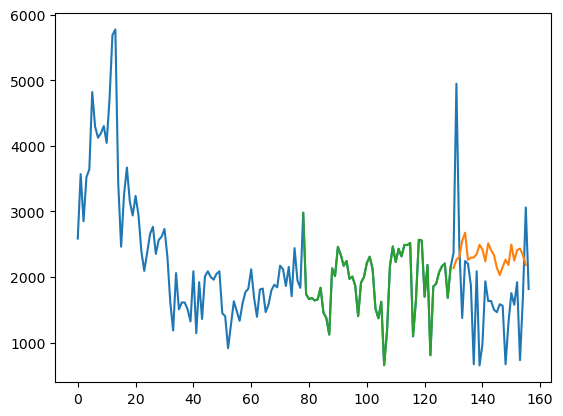

26


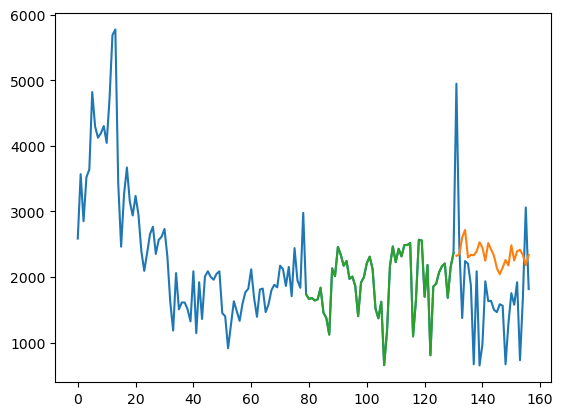

(2, 26)
26


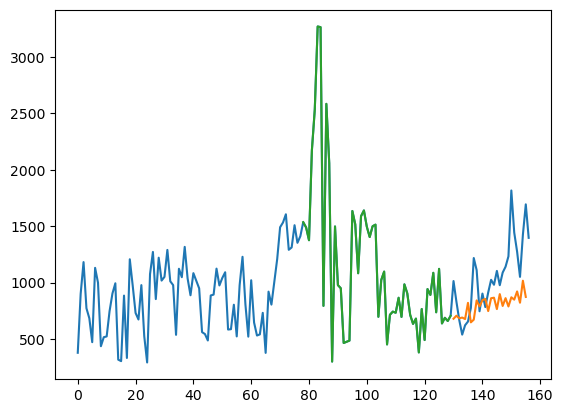

26


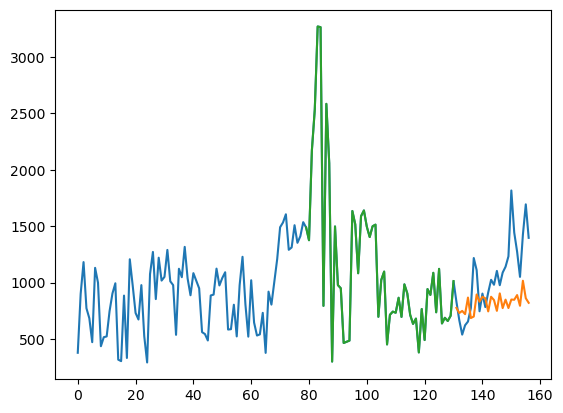

(2, 26)
26


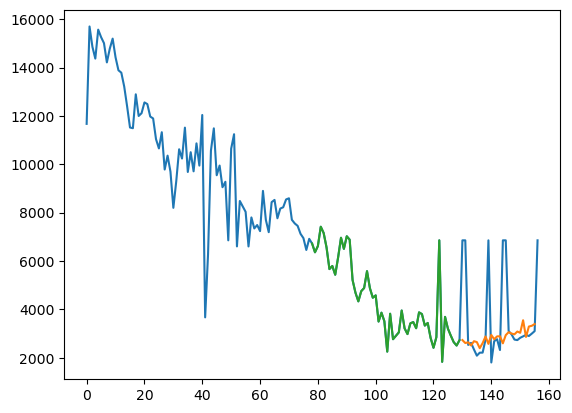

26


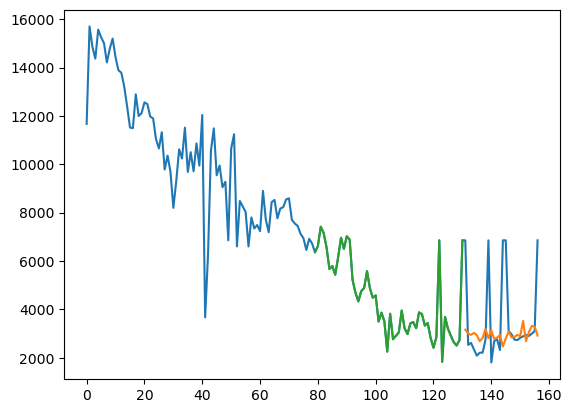

(2, 26)
26


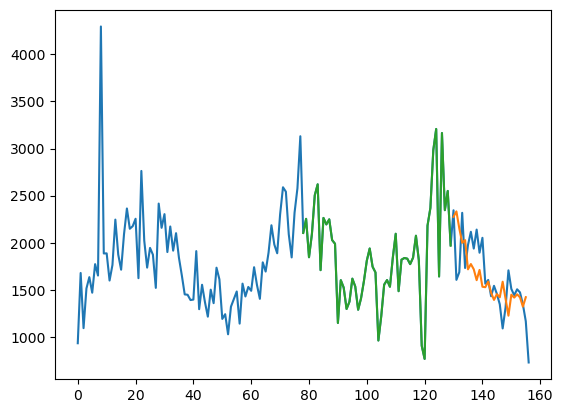

26


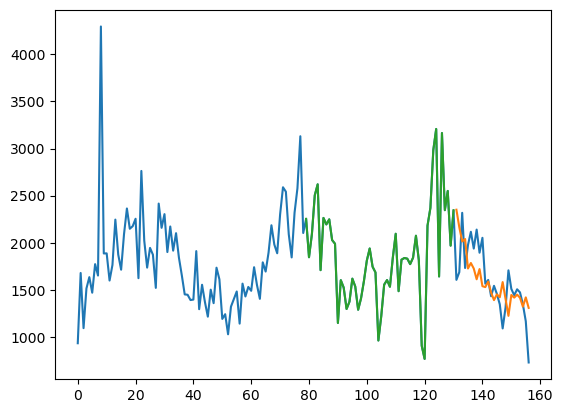

(2, 26)
26


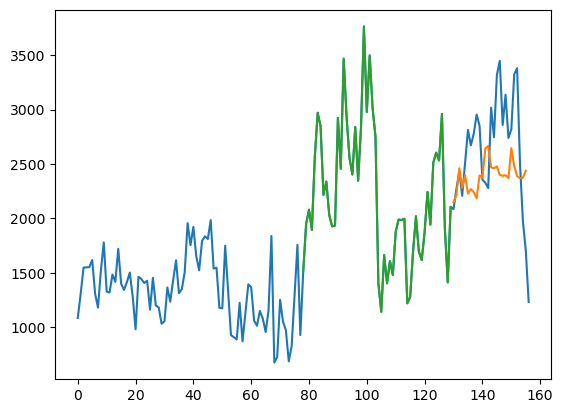

26


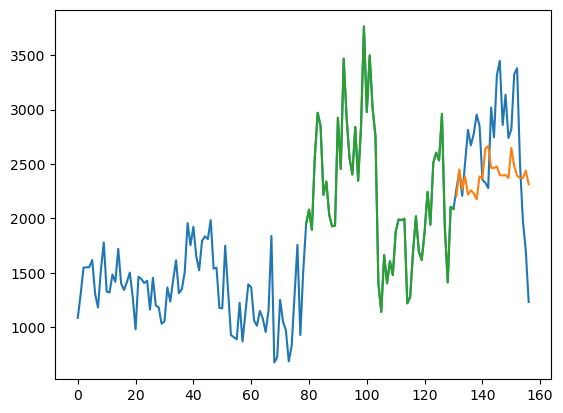

In [624]:
offset = 0
print("forecastingHorizon", forecastingHorizon, "indirectForecastingHorizon ", indirectForecastingHorizon)
for (idx, dataset) in enumerate(fullDataset) : 
    print(TestDatasetPredictions[idx].shape)
    for index in range (len(TestDatasetPredictions[idx])):
        individualTestInputsPlot = np.empty_like(dataset)
        individualTestInputsPlot = [np.nan] * len(individualTestInputsPlot)
        print(len(TrainDatasetPredictions[idx][0]))
        individualTestInputsPlot[len(TrainDatasetPredictions[idx][0])+index+timestamp+offset:len(TrainDatasetPredictions[idx])+index+timestamp*2+offset] = TestDatasetInputs[idx,index]
        individualTestPredictPlot = np.empty_like(dataset)
        individualTestPredictPlot = [np.nan] * len(individualTestPredictPlot)
        individualTestPredictPlot[len(TrainDatasetPredictions[idx][0])+index+timestamp*2:len(TrainDatasetPredictions[idx])+index+2*timestamp+2*realForecastingHorizon-1] = TestDatasetPredictions[idx,index]

        plt.plot(dataset)
        plt.plot(individualTestPredictPlot)
        plt.plot(individualTestInputsPlot)
        plt.show()

In [ ]:
a = np.array([[[1, 2], [3, 4]]])
b = np.array([[[5, 6]]])
print(a.shape, b.shape)
np.concatenate((a, b), axis=1)